In [2]:
import numpy as np
import time
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

# Introduction

In this notebook, we will measure empirically the variance of (Optical) Random Features. 

We will measure it two different ways:
- variance of the estimated kernel
- mean square error deviation with the true kernel (the one that we approximate)

# Variance measurement on random data

In [3]:
# Generate data
d = 512
x = np.random.randn(d)
y = np.random.randn(d)

# Orthogonalize y (not necessary, just to control well the angle between x and y)
x /= np.linalg.norm(x)
y /= np.linalg.norm(y)
y -= y * (y.T @ x)
y /= np.linalg.norm(y)

In [4]:
# Find variance for smaller n
n = 1000
n_rep = 25
theta_vec = np.arange(-np.pi/2, np.pi/2+1e-5, np.pi/30)
n_theta = len(theta_vec)
kernel_data = np.zeros((n_theta, n_rep))

for i_rep in tqdm(range(n_rep)):
    W = (np.random.randn(n, d) + 1j * np.random.randn(n, d)) / np.sqrt(2)
    phi_x = W @ x
    phi_y = W @ y
    phi2_x = np.abs(phi_x) ** 2
    for i, theta in enumerate(theta_vec):
        phi_z = np.cos(theta) * phi_x + np.sin(theta) * phi_y
        phi2_z = np.abs(phi_z) ** 2
        kernel_data[i, i_rep] = phi2_z.T @ phi2_x / n

100%|██████████| 25/25 [00:02<00:00,  8.85it/s]


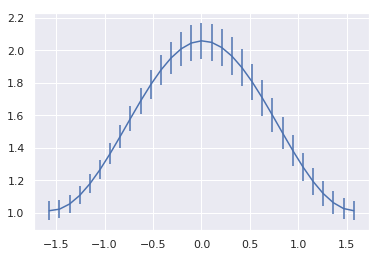

In [5]:
mean_kernel = np.mean(kernel_data, axis=1)
yerr = np.std(kernel_data, axis=1)
plt.errorbar(theta_vec, mean_kernel, yerr=yerr);

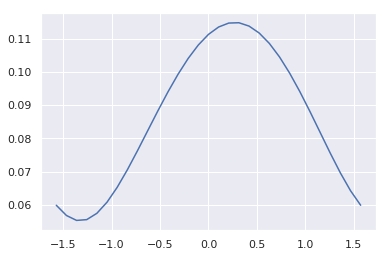

In [6]:
plt.plot(theta_vec, yerr);

In [8]:
n_vec = np.logspace(2, 4.5, num=25, dtype='uint64')
n_rep = 100
theta_vec = np.arange(-np.pi/2, np.pi/2+1e-5, np.pi/30)
n_theta = len(theta_vec)

kernel_data1 = np.zeros((len(n_vec), n_theta, n_rep))
final_err1 = np.zeros(len(n_vec))
kernel_data2 = np.zeros((len(n_vec), n_theta, n_rep))
final_err2 = np.zeros(len(n_vec))
kernel_data3 = np.zeros((len(n_vec), n_theta, n_rep))
final_err3 = np.zeros(len(n_vec))
kernel_data4 = np.zeros((len(n_vec), n_theta, n_rep))
final_err4 = np.zeros(len(n_vec))
for i_n, n in tqdm(enumerate(n_vec)):
    for i_rep in range(n_rep):
        # Gaussian transform
        W = (np.random.randn(n, d) + 1j * np.random.randn(n, d)) / np.sqrt(2)
        phi_x = W @ x
        phi_y = W @ y
        phi1_x = np.abs(phi_x)
        phi2_x = np.abs(phi_x) ** 2
        phi3_x = np.abs(phi_x) ** 3
        phi4_x = np.abs(phi_x) ** 4
        for i, theta in enumerate(theta_vec):
            phi_z = np.cos(theta) * phi_x + np.sin(theta) * phi_y
            phi1_z = np.abs(phi_z)
            phi2_z = np.abs(phi_z) ** 2
            phi3_z = np.abs(phi_z) ** 3
            phi4_z = np.abs(phi_z) ** 4
            kernel_data1[i_n, i, i_rep] = phi1_z.T @ phi1_x / n
            kernel_data2[i_n, i, i_rep] = phi2_z.T @ phi2_x / n
            kernel_data3[i_n, i, i_rep] = phi3_z.T @ phi3_x / n
            kernel_data4[i_n, i, i_rep] = phi4_z.T @ phi4_x / n
    final_err1[i_n] = np.mean(np.std(np.squeeze(kernel_data1[i_n, :, :]), axis=1))
    final_err2[i_n] = np.mean(np.std(np.squeeze(kernel_data2[i_n, :, :]), axis=1))
    final_err3[i_n] = np.mean(np.std(np.squeeze(kernel_data3[i_n, :, :]), axis=1))
    final_err4[i_n] = np.mean(np.std(np.squeeze(kernel_data4[i_n, :, :]), axis=1))


0it [00:00, ?it/s]
1it [00:00,  1.06it/s]
2it [00:02,  1.01s/it]
3it [00:03,  1.12s/it]
4it [00:05,  1.30s/it]
5it [00:07,  1.55s/it]
6it [00:09,  1.86s/it]
7it [00:13,  2.29s/it]
8it [00:17,  2.85s/it]
9it [00:22,  3.57s/it]
10it [00:29,  4.47s/it]
11it [00:37,  5.48s/it]
12it [00:46,  6.53s/it]
13it [00:56,  7.72s/it]
14it [01:08,  9.10s/it]
15it [01:23, 10.81s/it]
16it [01:41, 12.91s/it]
17it [02:03, 15.62s/it]
18it [02:30, 18.98s/it]
19it [03:03, 23.39s/it]
20it [03:45, 28.79s/it]
21it [04:43, 37.64s/it]
22it [05:56, 48.20s/it]
23it [07:28, 61.23s/it]
24it [09:23, 77.45s/it]
25it [11:49, 98.03s/it]

Note: This is not the most efficient way to compute the graph. It would be better to just make a very large random projection and subsample it.

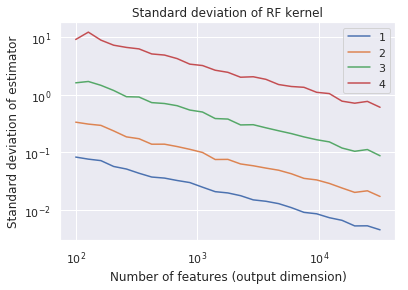

In [9]:
plt.loglog(n_vec, final_err1)
plt.loglog(n_vec, final_err2)
plt.loglog(n_vec, final_err3)
plt.loglog(n_vec, final_err4)
plt.legend(['1', '2', '3', '4'])
plt.xlabel('Number of features (output dimension)')
plt.ylabel('Standard deviation of estimator')
plt.title('Standard deviation of RF kernel');

# Deviation with true kernel

We want to approximate the kernel: $K(x,y) = 1 + \langle x, y \rangle^2$ (assuming that $x$ and $y$ are normalized).

In this paragraph, we only consider the simplest optical random features (power 2).

In [17]:
cos_vec = np.cos(theta_vec)
true_kernel = 1 + cos_vec**2
true_kernel = np.tile(true_kernel[:, np.newaxis], (len(n_vec), 1, n_rep))

mse = np.mean(np.mean((kernel_data2 - true_kernel)**2, axis=2), axis=1)

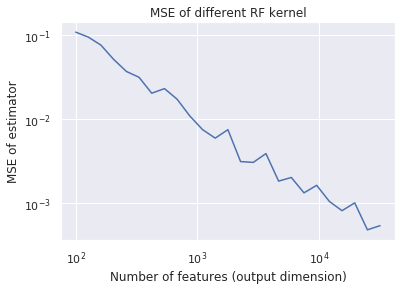

In [20]:
plt.loglog(n_vec, mse)
plt.xlabel('Number of features (output dimension)')
plt.ylabel('MSE of estimator')
plt.title('MSE of different RF kernel');